In [41]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

all_vars = ["t","D","E","H","I","ICU","N","R","Rq","S"]
simpler_vars = ["t","D","H","ICU","Rq"]

activities_to_train = ["work","leisure","other","transport","school"]

vars_to_use = all_vars
tree_depth = 6
population = 12278210

In [42]:
data = pd.read_csv("data.csv")
print(data.columns)
print(len(data))
data["I"] = data["I"]/population

Index(['Unnamed: 0', 't', 'id', 'D', 'E', 'H', 'I', 'ICU', 'Ia', 'Ims', 'Ips',
       'Iss', 'N', 'R', 'Rq', 'S', 'home', 'leisure', 'other', 'school',
       'transport', 'work'],
      dtype='object')
90000


In [43]:
models = {}
for act in activities_to_train:
    clf = tree.DecisionTreeRegressor(max_depth=tree_depth)
    clf = clf.fit(data[vars_to_use], data[act])
    models[act] = clf


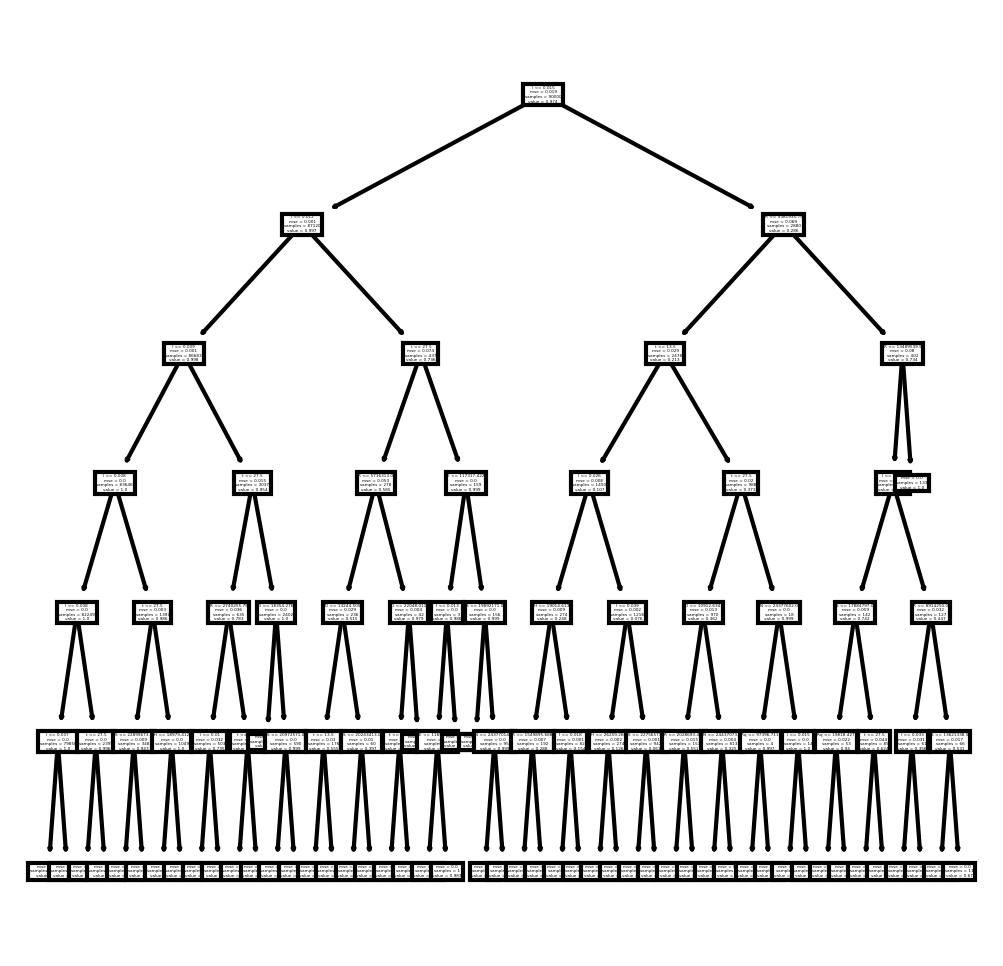

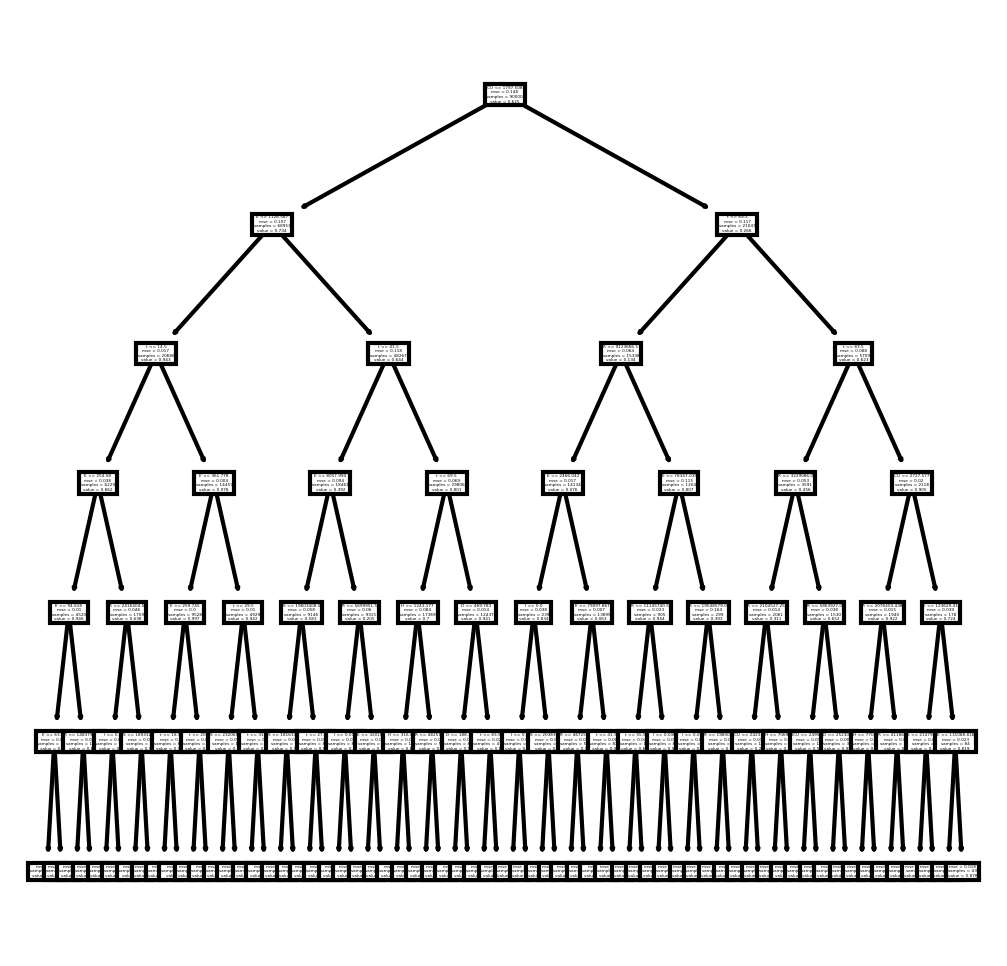

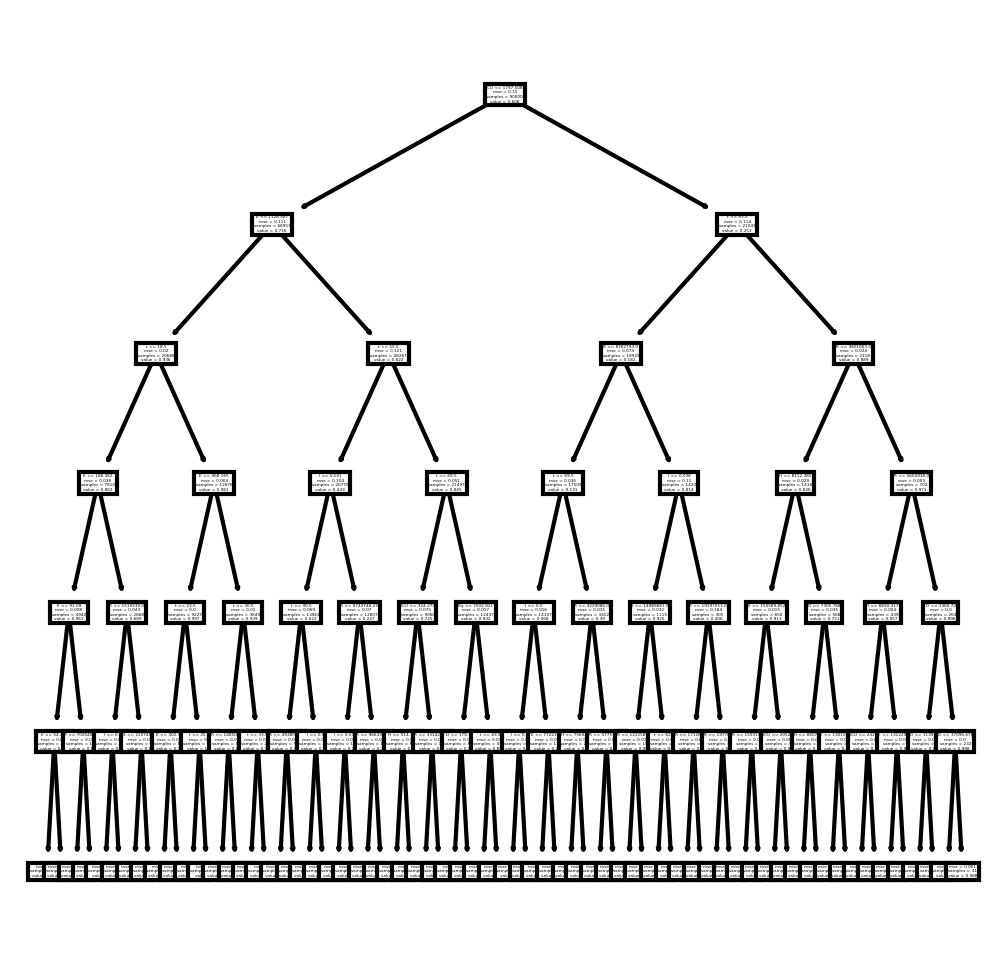

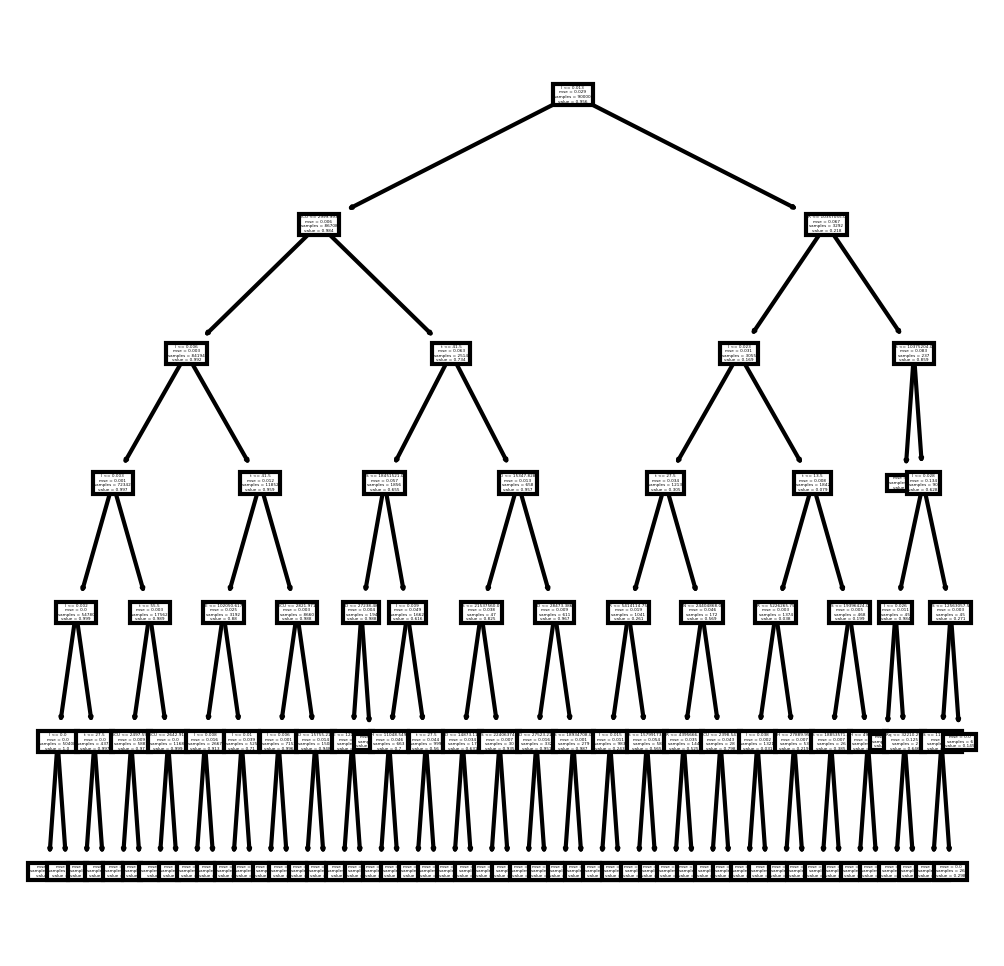

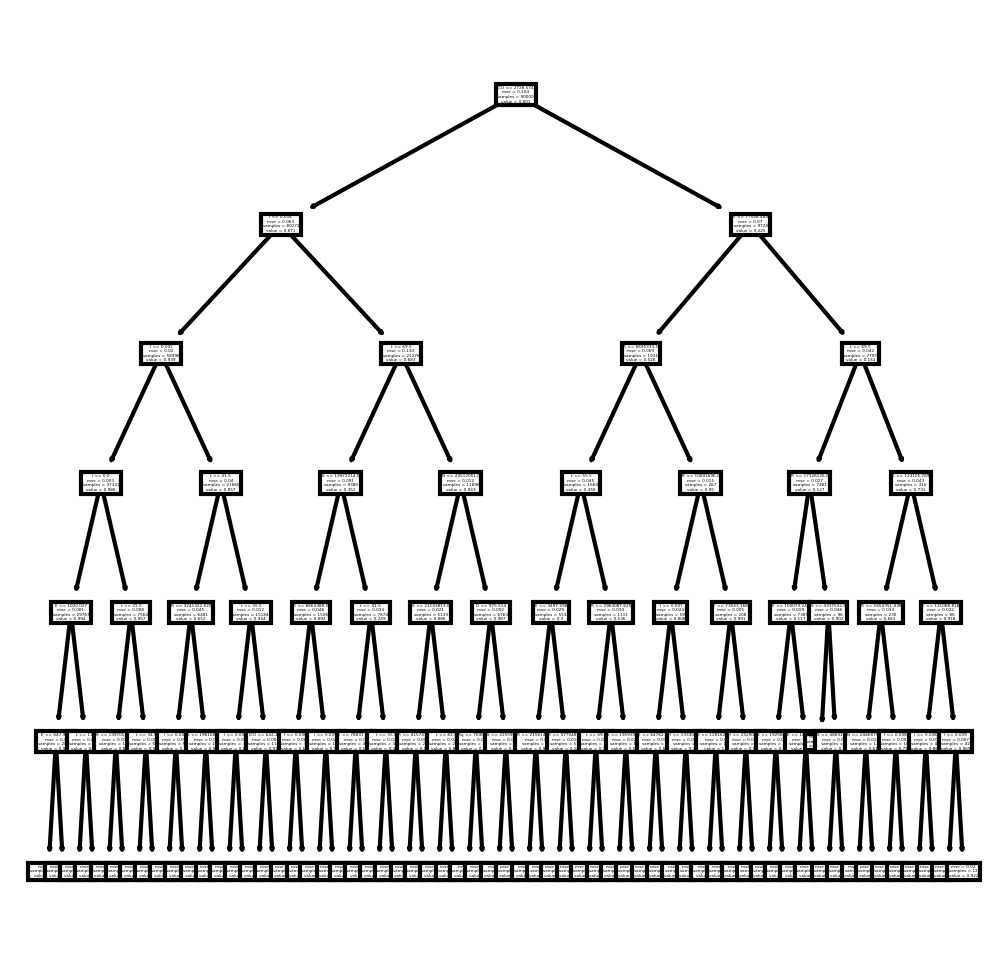

In [44]:
# Plot
for act in activities_to_train:
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    tree.plot_tree(models[act], feature_names=vars_to_use) 
    fig.savefig('%s.png'%act)

In [45]:
import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, current_dir+"/heuristics")
sys.path.insert(0, parent_dir+"/fast_gradient")
sys.path.insert(0, current_dir+"/heuristics/LP-Models")
parent_dir = current_dir[:current_dir.rfind(os.path.sep)]
sys.path.insert(0, parent_dir)

from group import SEIR_group, DynamicalModel
import math
import pprint
import pandas as pd
import pickle
import numpy as np
from fast_group import FastDynamicalModel
from aux import *
from scipy.optimize import Bounds,minimize,LinearConstraint
from copy import deepcopy


# Parameters to try
with open("../parameters/run_params.yaml") as file:
        run_params = yaml.load(file, Loader=yaml.FullLoader)

params_to_try = run_params["params_to_try"]
groups = run_params["groups"]

proportions = {'age_group_0_9': 0.12999753718396828, 'age_group_10_19': 0.1260199381062682, 'age_group_20_29': 0.13462273540296374, 'age_group_30_39': 0.1432185965976917, 'age_group_40_49': 0.13619350895266272, 'age_group_50_59': 0.1252867882416867, 'age_group_60_69': 0.09586005862219948, 'age_group_70_79': 0.06449748382900194, 'age_group_80_plus': 0.044303353063557066}


# Global variables
simulation_params = {
    'dt':1.0,
    'days': 90.0,
    'region': "fitted",
    'heuristic': 'benchmark',
    'mixing_method': {'name': 'multi'}
}
simulation_params['time_periods'] = int(math.ceil(simulation_params["days"]/simulation_params["dt"]))

if groups == "all":
    age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29', 'age_group_30_39', 'age_group_40_49',
    'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']

    # Read group parameters
    with open("../parameters/fitted.yaml") as file:
        universe_params = yaml.load(file, Loader=yaml.FullLoader)

    # Read initialization
    with open("../initialization/60days.yaml") as file:
        initialization = yaml.load(file, Loader=yaml.FullLoader)
        start_day = 60

    # Read econ parameters
    with open("../parameters/econ.yaml") as file:
        econ_params = yaml.load(file, Loader=yaml.FullLoader)

elif groups == "one":
    age_groups = ["all_age_groups"]

    # Read group parameters
    with open("../parameters/one_group_fitted.yaml") as file:
        universe_params = yaml.load(file, Loader=yaml.FullLoader)

    # Read initialization
    with open("../initialization/60days_one_group.yaml") as file:
        initialization = yaml.load(file, Loader=yaml.FullLoader)
        start_day = 60

    # Read econ parameters
    with open("../parameters/one_group_econ.yaml") as file:
        econ_params = yaml.load(file, Loader=yaml.FullLoader)


cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips', \
       'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]
activities = ['home','leisure','other','school','transport','work']
rel_activities = ['leisure','other','school','transport','work']


# Define time variables
simulation_params['time_periods'] = int(math.ceil(simulation_params["days"]/simulation_params["dt"]))


# Define mixing parameter
mixing_method = universe_params["mixing"]



In [46]:
experiment_params = {
    'delta_schooling':0.5,
    'xi':1115970.9,
    'icus':3000,
    'testing':"homogeneous",
    'tests':[0,0],
    'eta':0.1,
}

In [47]:
def predict_from_state(state_result):
    alpha = {"home":1.0}
    for act in activities_to_train:
        x = [state_result[c] for c in vars_to_use]
        alpha[act] = models[act].predict([x])[0]
    return {"all_age_groups":alpha}

In [48]:
# Create dynamical method

ag_alpha = {
    "home": 1.0,
    "leisure": 0,
    "other": 0,
    "school": 0,
    "transport": 0,
    "work": 0,
}

alpha = {
    ag:deepcopy(ag_alpha) for ag in age_groups
}

l_policy = []
a_tests_policy = []
m_tests_policy = []
dynModel = DynamicalModel(universe_params, econ_params, experiment_params, initialization, simulation_params['dt'], simulation_params['time_periods'], mixing_method, start_day, experiment_params["eta"])
if experiment_params["testing"] == "homogeneous":
    m_tests = {ag:experiment_params["tests"][0]/len(age_groups) for ag in age_groups}
    a_tests = {ag:experiment_params["tests"][1]/len(age_groups) for ag in age_groups}

state_result = initialization['all_age_groups']
state_result["t"]=0
state_result["I"] = state_result["I"]/population
alpha = predict_from_state(state_result)
for t in range(simulation_params['time_periods']):
    step_result = dynModel.take_time_step(m_tests, a_tests, alpha)
    state_result = step_result['state']['all_age_groups']
    state_result["I"] = state_result["I"]/population
    state_result["t"]=t+1
    alpha = predict_from_state(state_result)
    l_policy.append(deepcopy(alpha))
    a_tests_policy.append(deepcopy(a_tests))
    m_tests_policy.append(deepcopy(m_tests))

end_alphas, end_a_tests, end_m_tests = dynModel.take_end_steps()

l_policy += end_alphas
a_tests_policy += end_a_tests
m_tests_policy += end_m_tests

print(float(dynModel.get_total_deaths()))
print(float(dynModel.get_total_economic_value()))
print(float(dynModel.get_total_reward())/1e9)



7182.0261822102675
49020510115.62352
38.63595198128934


In [49]:
38.6/34

1.1352941176470588

In [613]:
initialization

{'all_age_groups': {'D': 482.93787169146765,
  'E': 277187.12140755146,
  'H': 5879.35910757632,
  'I': 212207.0033700298,
  'ICU': 1613.043161735563,
  'Ia': 0.0,
  'Ims': 0.0,
  'Ips': 0.0,
  'Iss': 0.0,
  'N': 12267611.504317332,
  'R': 408171.7460135,
  'Rq': 2623.154481818964,
  'S': 11370045.633526247,
  't': 0}}

In [614]:
12267611.504317332+2623.154481818964+1613.043161735563+482.93787169146765+5879.35910757632

12278209.998940153